# Resonant Periodic Orbits
In this tutorial, we'll use the `PlanarResonanceEquations` class from `celmech.numerical_resonance_models` to map out the equilibrium points of a mean motion resonance (sometimes also referred to as 'periodic orbits' or 'apsidal co-rotation resonances', see, e.g., [Hadden & Payne (2020)](https://ui.adsabs.harvard.edu/abs/2020AJ....160..106H/abstract) and references therein).

These dynamical configurations are the natural outcome of resonant capture through smooth migration and eccentricity damping in, e.g., a protoplanetary disk. They also form the phase space 'skeleton' around which more general resonant motion occurs.

In [1]:
import numpy as np
import rebound as rb
from celmech.numerical_resonance_models import PlanarResonanceEquations
import matplotlib.pyplot as plt
%matplotlib inline

We begin by initializing the `PlanarResonanceEquations` object we'll use for our calculations.

In [2]:
res_eqs = PlanarResonanceEquations(3,1)

We'll solve for resonant equilibria for a few different planet mass combinations, using the function defined below to set the planet masses of our `res_eqs` object.

In [3]:
def set_planet_mass_ratio_and_total(res_eqs,mtot,m2bym1):
    m1 = mtot / (1 + m2bym1)
    m2 = mtot - m1
    res_eqs.m1 = m1
    res_eqs.m2 = m2

In [4]:
# Total mass of planets relative to star
mtot = 5e-4 

# List of m2/m1 ratios, where m1 and m2 are the inner and outer planet masses
mratios = [1/3.,1.,3.] 

Given a pair of planet masses, $(m_1,m_2)$, the periodic orbits of a $j:j-k$ mean motion resonance form a one-parameter family of orbits. The quantity 
\begin{equation}
{\cal D} \approx \frac{1}{2}\beta_1\sqrt{\alpha}e_1^2+\frac{1}{2}\beta_2e_2^2 - \frac{k\beta_1\beta_2\sqrt{\alpha}\Delta}{3(\beta_1\sqrt{\alpha}(s+1) + \beta_2 s)},
\end{equation}
where $\beta_i = m_i/(m_1+m_2)$, $\Delta = \frac{j-k}{j}\frac{P_2}{P_1} - 1$, and $s=(j-k)/k$,  provides a convenient parameter for specifying the individual orbits of the the one-parameter family of periodic orbits. This quantity is conserved by the resonant dynamics and plays a role analogous to the role of a system's angular momentum deficit in secular dynamics (see, e.g., [Hadden (2019)](https://ui.adsabs.harvard.edu/abs/2019AJ....158..238H/abstract), [Hadden & Payne (2020)](https://ui.adsabs.harvard.edu/abs/2020AJ....160..106H/abstract)).



In order to specify the range of ${\cal D}$ values over which we will solve for periodic orbits, we define `emin` and `emax` below. 
For each combination of planet masses, we solve for the periodic orbits with 
\begin{equation}
    \frac{1}{2}\left(\beta_1\sqrt{\alpha}+\beta_2\right)e_\mathrm{min}^2
    \le
    {\cal D}
    \le
    \frac{1}{2}\left(\beta_1\sqrt{\alpha}e_1^2+\beta_2\right)e_\mathrm{max}^2
\end{equation}

In [5]:
emin = 0.005
emax = 0.3
# Number of orbits to determine for each set of planet masses
ND = 150

Now we'll use the `PlanarResonanceEquations.find_equilibrium` method in order to solve for our families of periodic orbits

In [6]:
Nmratio = len(mratios)

# Array to store equilibrium dynamical variables
eq_vars = np.zeros((Nmratio,ND,5))

# Loop over planet mass combinations
for i,mratio in enumerate(mratios):
    set_planet_mass_ratio_and_total(res_eqs,mtot,mratio)
    
    # Define range of {\cal D} values
    Dmin = 0.5 * (res_eqs.beta1*np.sqrt(res_eqs.alpha) +res_eqs.beta2) * emin**2
    Dmax = 0.5 * ( res_eqs.beta1*np.sqrt(res_eqs.alpha) +res_eqs.beta2) * emax**2
    Dvals = np.linspace(Dmin,Dmax,ND)

    
    # Guess for initial periodic orbit
    guess_vars = [0,0,1e-2,1e-2,Dmin]
    y=res_eqs.find_equilibrium(guess_vars,max_iter=25)
    
    # Solve for equilbria at different D values
    for j,D in enumerate(Dvals):
        y[-1]=D
        y=res_eqs.find_equilibrium(y,max_iter=15)
        eq_vars[i,j] = y

Now we'll convert our equilibrium solutions to orbital elements:

In [7]:
e1,e2,Delta = np.zeros((3,Nmratio,ND))
for i,mratio in enumerate(mratios):
    for j,dyvars in enumerate(Dvals):
        els = res_eqs.dyvars_to_orbital_elements(eq_vars[i,j])
        e1[i,j]=els['e1']
        e2[i,j]=els['e2']
        a1=els['a1']
        a2=els['a2']
        pratio = (a2/a1)**(1.5)
        Delta[i,j] = (res_eqs.j - res_eqs.k) * pratio / res_eqs.j - 1

And plot our solutions:

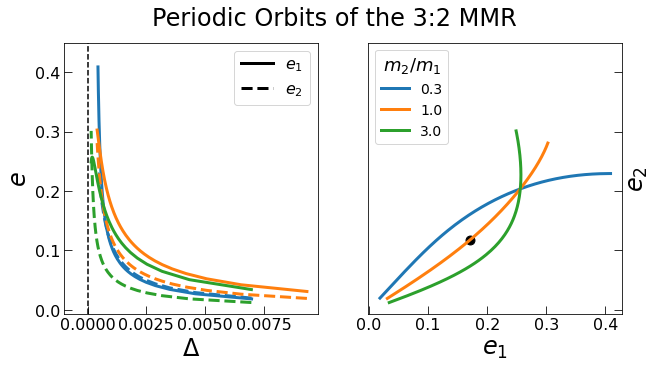

In [8]:
#  We'll initialize a rebound example below; here we'll plot its location in the (e1,e2) plane
Iexample = 1
Jexample = ND//5

fig,ax = plt.subplots(1,2,sharey=True,figsize=(10,5))
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
for i,mr in enumerate(mratios):
    l,=ax[0].plot(Delta[i],e1[i],lw=3)
    col=l.get_color()
    # Delta vs e
    ax[0].plot(Delta[i],e2[i],lw=3,ls='--',color=col)
    
    # e vs e
    ax[1].plot(e1[i],e2[i],label="{:.1f}".format(mr),lw=3,color=col)
ax[1].legend(title=r"$m_2/m_1$",fontsize=14,title_fontsize=18)
ax[1].set_xlabel(r"$e_1$",fontsize=24)
ax[1].set_ylabel(r"$e_2$",fontsize=24)


ax[0].set_ylabel(r"$e$",fontsize=24)
ax[0].set_xlabel(r"$\Delta$",fontsize=24)
ax[0].set_xlim(xmin=-0.001)
ax[0].axvline(0.,ls='--',color='k')

for a in ax:
    plt.sca(a)
    plt.tick_params(size=8,direction='in',labelsize=16)
fig.suptitle("Periodic Orbits of the {}:{} MMR".format(res_eqs.j,res_eqs.j-res_eqs.k),fontsize=24)
ax[0].set_ylim(ymax=0.45)


from matplotlib.lines import Line2D
legend_elements = [ 
    Line2D([0],[0],color='k',ls='-', lw=3,label=r'$e_1$'),
    Line2D([0],[0],color='k',ls='--', lw=3,label=r'$e_2$')
]
ax[0].legend(handles=legend_elements,fontsize=16)

ax[1].scatter(e1[Iexample,Jexample],e2[Iexample,Jexample],color='k',s=80)

Now we'll initialize a `rebound.Simulation` object at one of the equilibria/periodic orbits (specified in the cell above with `Iexample`,`Jexample`). 

The `osculating_correction=True` option is neccessary to ensure that the $N$-body simlution is intialized precisely in the periodic orbit. 

Below, we'll compare simulations initialized with and without applying this correction.

In [9]:
Q0 = 0 # np.random.uniform(-np.pi,np.pi)
dyvars = eq_vars[Iexample,Jexample]
set_planet_mass_ratio_and_total(res_eqs,mtot,mratios[Iexample])
sim = res_eqs.dyvars_to_rebound_simulation(dyvars, Q = Q0, osculating_correction=True)
sim_nc = res_eqs.dyvars_to_rebound_simulation(dyvars, Q = Q0, osculating_correction=False)

Now we'll integrate for a few synodic periods
\begin{equation}
T_\mathrm{syn} = \frac{2\pi}{n_1-n_2}
\end{equation}, to show that our planets are in fact on a periodic with period $k T_\mathrm{syn}$.

In [10]:
ps = sim.particles
# synodic frequency
n_syn = np.array([1,-1]) @ [p.n for p in ps[1:]]
T_syn = 2*np.pi / n_syn
Tmax = 12 * T_syn
Nout = 200

In [11]:
print(n_syn)

0.4866699613204777


In [12]:
sim.automateSimulationArchive("periodic_orbit.sa",interval=Tmax/Nout,deletefile=True)
sim.integrate(Tmax)

sim_nc.automateSimulationArchive("near_periodic_orbit.sa",interval=Tmax/Nout,deletefile=True)
sim_nc.integrate(Tmax)

In [13]:
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
nbresults = get_simarchive_integration_results("./periodic_orbit.sa",coordinates='heliocentric')
nbresults_nc = get_simarchive_integration_results("./near_periodic_orbit.sa",coordinates='heliocentric')

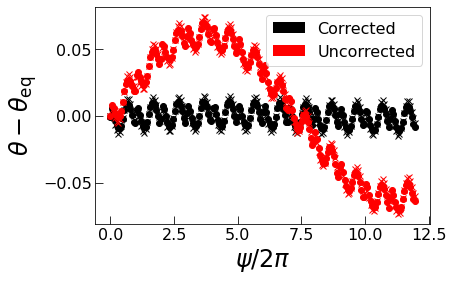

In [15]:
els_eq = res_eqs.dyvars_to_orbital_elements(eq_vars[Iexample,Jexample])
for col,results in zip("kr",[nbresults,nbresults_nc]):
    # synodic angle
    psi = np.array([1,-1]) @ results['l']
    psi = np.mod(psi + np.pi,2*np.pi) - np.pi
    xcoord = 0.5 * np.unwrap(psi)/np.pi
    # resonant angles
    theta_res = np.array([res_eqs.k - res_eqs.j, res_eqs.j]) @ results['l'] - res_eqs.k * results['pomega']
    theta_res = np.mod(theta_res,2*np.pi)
    
    # 
    dtheta1 = np.mod(theta_res[0]-els_eq['theta1']+np.pi,2*np.pi)-np.pi
    dtheta2 = np.mod(theta_res[1]-els_eq['theta2']+np.pi,2*np.pi)-np.pi
    plt.plot(xcoord,dtheta1,'o',color=col)
    plt.plot(xcoord,dtheta2,'x',color=col)
    
plt.xlabel(r"$\psi/2\pi$",fontsize=24)    
plt.tick_params(size=8,direction='in',labelsize=16)
plt.ylabel(r"$\theta - \theta_\mathrm{eq}$",fontsize=24)

from matplotlib.patches import Patch
legend_elements = [ Patch(facecolor='k', label='Corrected'),Patch(facecolor='red', label='Uncorrected')]
plt.legend(handles=legend_elements,fontsize=16)